In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [26]:
# get the data of eurusd for given range
start_date = '2005-01-01'
end_date = '2024-05-01'

eur_usd_data_daily = yf.download('EURUSD=X', start=start_date, end=end_date)
eur_usd_data_monthly = yf.download('EURUSD=X', start=start_date, end=end_date, interval='1mo')

GSPC_data_monthly = yf.download('^GSPC', start='2004-12-01', end=end_date, interval='1mo')
STOXX50E_data_monthly = pd.read_csv('csv_files/STOXX50E.csv')

eur_usd_data_monthly.head(5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-01,1.356594,1.362695,1.293193,1.305193,1.305193,0
2005-02-01,1.305006,1.328004,1.273707,1.321702,1.321702,0
2005-03-01,1.321895,1.347909,1.286107,1.296697,1.296697,0
2005-04-01,1.296798,1.311699,1.277906,1.292307,1.292307,0
2005-05-01,1.292307,1.298701,1.229997,1.230800,1.230800,0


In [27]:
# create a new dataframe to store the monthly data, indexes should be at the format: "2005-01"
feature_set = pd.DataFrame(index=eur_usd_data_daily.resample('M').mean().index.strftime('%Y-%m'), columns=['volatility'])

# calculate the volatility for each month
for month in feature_set.index:
    start_date = month
    end_date = pd.to_datetime(start_date) + pd.DateOffset(months=1)
    feature_set.loc[month] = round((eur_usd_data_daily.loc[start_date:end_date].Close.std()) * (len(eur_usd_data_daily.loc[start_date:end_date]) ** (1/2)) * 100, 3)

feature_set['volatility'] = feature_set['volatility'].astype(float) 
# print the monthly data
feature_set.head(10)

,volatility
Date,
2005-01,5.857
2005-02,7.158
2005-03,9.594
2005-04,3.802
2005-05,9.314
2005-06,4.344
2005-07,4.206
2005-08,4.595
2005-09,8.196


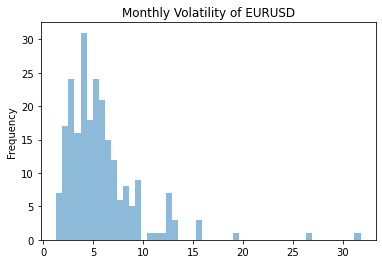

Mean: 5.7831250000000045
Standard Deviation: 3.7051241441686265
Number of months that have volatility smaller than 6: 154


In [28]:
# make a histogram of the monthly volatility
feature_set['volatility'].plot.hist(bins=50, alpha=0.5, title='Monthly Volatility of EURUSD')
plt.show()

# mean and standard deviation of the monthly volatility
mean = feature_set.volatility.mean()
std = feature_set.volatility.std()
print('Mean:', mean)
print('Standard Deviation:', std)

# print the ncount of the rows that are smaller than the mean + 1 std
threshold = 6
print(f'Number of months that have volatility smaller than {threshold}:', len(feature_set[feature_set.volatility < threshold]))

In [29]:
# add a low/high column that labels the month as low or high volatility according to the threshold
feature_set['low/high'] = np.where(feature_set.volatility < threshold, 0, 1)

# print the monthly data with the low/high column
feature_set.head()

,volatility,low/high
Date,,
2005-01,5.857,0
2005-02,7.158,1
2005-03,9.594,1
2005-04,3.802,0
2005-05,9.314,1


In [32]:
# adding related features to the monthly data

# add the percentage change of the previous month
feature_set['abs_pct_change_monthly'] = abs(np.array(eur_usd_data_monthly['Close'].pct_change()))

# add max_abs_return_daily
current_month = eur_usd_data_daily.index[0].strftime('%Y-%m')
prices = []
pct_dict = {}

for idx, daily in eur_usd_data_daily.iterrows():
    if current_month != idx.strftime('%Y-%m'):
        pct_dict[current_month] = max(abs(pd.Series(prices).pct_change().max()), abs(pd.Series(prices).pct_change().min()))
        prices = []
        current_month = idx.strftime('%Y-%m')
    else:
        prices.append(daily["Close"])

feature_set['max_abs_return_daily'] = feature_set.index.map(pct_dict)

# add the fedfunds.csv file
fed_funds = pd.read_csv('csv_files/FEDFUNDS.csv')
feature_set['fed_funds'] = np.array(fed_funds[fed_funds["DATE"] > "2004-11-31"]['FEDFUNDS'])[1:]

# add the 10 year treasury rate
ten_year_treasury = pd.read_csv('csv_files/GS10.csv')
feature_set['10_year_treasury'] = np.array(ten_year_treasury[ten_year_treasury["DATE"] > "2004-11-10"]['GS10'])[1:]

# add ecb interest rate
ecb_interest = pd.read_csv('csv_files/ECBRATES.csv', header=None)
feature_set['ecb_interest'] = np.array(ecb_interest[ecb_interest[0] > "2004-12-31"][1])

# add the interest rate difference between ecb and fed
feature_set['interest_diff'] = feature_set['ecb_interest'] - feature_set['fed_funds']

# add the monthly return of the S&P 500
feature_set['sp500_return'] = np.array(GSPC_data_monthly['Close'].pct_change())[1:]

# add the monthly return of the STOXX 50
feature_set['stoxx50_return'] = np.array(STOXX50E_data_monthly[STOXX50E_data_monthly["DATE"] > "2004-11-31"]['VALUES'].pct_change())[1:]

# add the difference between the S&P 500 and STOXX 50 returns
feature_set['sp500_stoxx50_diff'] = feature_set['sp500_return'] - feature_set['stoxx50_return']

In [33]:
# printing feature set
feature_set.head()

,volatility,low/high,abs_pct_change_monthly,max_abs_return_daily,fed_funds,10_year_treasury,ecb_interest,interest_diff,sp500_return,stoxx50_return,sp500_stoxx50_diff
Date,,,,,,,,,,,
2005-01,5.857,0,NaN,0.013959,2.28,4.22,2.0,-0.28,-0.025290,0.010604,-0.035894
2005-02,7.158,1,0.012649,0.015078,2.50,4.17,2.0,-0.50,0.018903,0.031585,-0.012681
2005-03,9.594,1,0.018919,0.012082,2.63,4.50,2.0,-0.63,-0.019118,0.005031,-0.024148
2005-04,3.802,0,0.003386,0.011495,2.79,4.34,2.0,-0.79,-0.020109,-0.016968,-0.003141
2005-05,9.314,1,0.047595,0.014019,3.00,4.14,2.0,-1.00,0.029952,0.003226,0.026726


In [34]:
# check correlation between the features
feature_set.corr()

,volatility,low/high,abs_pct_change_monthly,max_abs_return_daily,fed_funds,10_year_treasury,ecb_interest,interest_diff,sp500_return,stoxx50_return,sp500_stoxx50_diff
volatility,1.000000,0.700164,0.767502,0.739670,-0.187798,0.059841,0.159713,0.494072,-0.160673,-0.208773,0.055691
low/high,0.700164,1.000000,0.540943,0.347192,-0.228029,0.014841,0.038713,0.407417,-0.098203,-0.098322,0.002251
abs_pct_change_monthly,0.767502,0.540943,1.000000,0.458774,-0.156114,-0.025541,0.068247,0.330571,-0.096350,-0.064404,-0.032549
max_abs_return_daily,0.739670,0.347192,0.458774,1.000000,-0.103109,0.035425,0.181051,0.383332,-0.206707,-0.282836,0.087919
fed_funds,-0.187798,-0.228029,-0.156114,-0.103109,1.000000,0.770047,0.773078,-0.617368,-0.022980,0.065703,-0.095784
10_year_treasury,0.059841,0.014841,-0.025541,0.035425,0.770047,1.000000,0.780563,-0.245647,-0.088899,0.009453,-0.104857
ecb_interest,0.159713,0.038713,0.068247,0.181051,0.773078,0.780563,1.000000,0.021723,-0.107090,-0.057219,-0.051830
interest_diff,0.494072,0.407417,0.330571,0.383332,-0.617368,-0.245647,0.021723,1.000000,-0.096593,-0.174522,0.086690
sp500_return,-0.160673,-0.098203,-0.096350,-0.206707,-0.022980,-0.088899,-0.107090,-0.096593,1.000000,0.567380,0.448079
stoxx50_return,-0.208773,-0.098322,-0.064404,-0.282836,0.065703,0.009453,-0.057219,-0.174522,0.567380,1.000000,-0.481934


In [10]:
feature_set['low/high'] = feature_set['low/high'].shift(-1)
feature_set.dropna(inplace=True)
feature_set.head()

,volatility,low/high,abs_pct_change_monthly,max_abs_return_daily,fed_funds,10_year_treasury,ecb_interest,interest_diff
Date,,,,,,,,
2005-02,7.158,1.0,0.012649,0.015078,2.50,4.17,2.0,-0.50
2005-03,9.594,0.0,0.018919,0.012082,2.63,4.50,2.0,-0.63
2005-04,3.802,1.0,0.003386,0.011495,2.79,4.34,2.0,-0.79
2005-05,9.314,0.0,0.047595,0.014019,3.00,4.14,2.0,-1.00
2005-06,4.344,0.0,0.017629,0.014870,3.04,4.00,2.0,-1.04


In [11]:
x_data = feature_set.drop(columns=['volatility', 'low/high'], axis=1)
y_data = feature_set['low/high']

In [12]:
x_data = np.array(x_data)
y_data = np.array(y_data)

# randomize the data
np.random.seed(42)
np.random.shuffle(x_data)
np.random.seed(42)
np.random.shuffle(y_data)

x_train = x_data[:int(len(x_data) * 0.8)]
x_test = x_data[int(len(x_data) * 0.8):]

y_train = y_data[:int(len(y_data) * 0.8)]
y_test = y_data[int(len(y_data) * 0.8):]

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565 (2.21 KB)

 Trainable params: 565 (2.21 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2995 - loss: 0.2647 - val_accuracy: 0.3696 - val_loss: 0.2555
Epoch 2/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.3623 - loss: 0.2535 - val_accuracy: 0.7826 - val_loss: 0.2452
Epoch 3/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.7032 - loss: 0.2445 - val_accuracy: 0.7174 - val_loss: 0.2383
Epoch 4/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.6250 - loss: 0.2402 - val_accuracy: 0.7174 - val_loss: 0.2328
Epoch 5/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.6157 - loss: 0.2393 - val_accuracy: 0.7174 - val_loss: 0.2283
Epoch 6/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.6315 - loss: 0.2334 - val_accuracy: 0.7174 - val_loss: 0.2236
Epoch 7/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.6606 - loss: 0.2248 - val_accuracy: 0.7174 - val_loss: 0.2198
Epoch 8/10000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.6881 - loss

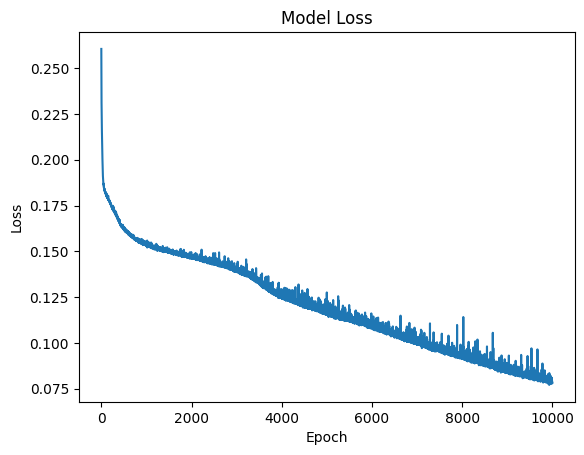

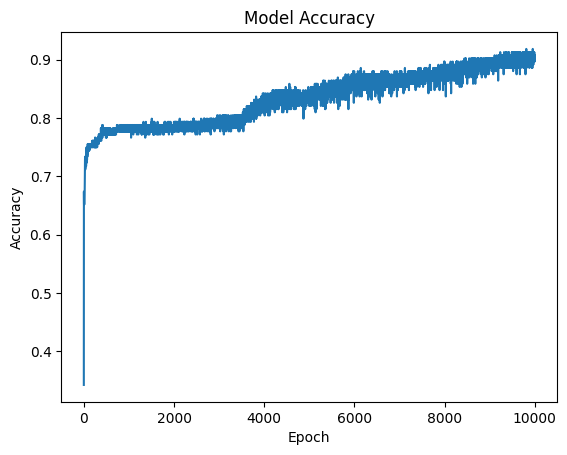

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7885 - loss: 0.1945 
Test Loss: 0.22504563629627228
Test Accuracy: 0.760869562625885


In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential()

# Add input layer
model.add(Dense(12, input_dim=6, activation='relu'))

# Add hidden layers
for _ in range(3):
    model.add(Dense(12, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Define the optimizer with a custom learning rate
custom_optimizer = Adam(learning_rate=0.0003)  # Change the learning rate as needed

# Compile the model with the custom optimizer
model.compile(optimizer=custom_optimizer, loss='mse', metrics=['accuracy'])
print(model.summary())
# Train the model
history = model.fit(x_train, y_train, epochs=10000, batch_size=8, verbose=1, validation_data=(x_test, y_test))

# Plot the loss function graph
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test the model
loss, accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [14]:
predict = pd.DataFrame(model.predict(x_test))
predict.to_excel('results/predict.xlsx', index=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [15]:
true = pd.DataFrame(y_test)
true.to_excel('results/true.xlsx', index=False)